# Finite Difference method for solving discrete Laplace Equation

### Exercise 1: solve the 4x4 linear equation A.x = b

`4*u[i,j] - u[i-1,j] - u[i+1,j] - u[i,j-1] - u[i,j+1] = 0`

Dervie and solve the linear system A.x =b

REF: https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve.html#scipy.linalg.solve

In [1]:
import numpy as np
from scipy import linalg

In [2]:
#TODO
A = np.array([[4,-1,-1,0],[-1,4,0,-1],[-1,0,4,-1],[0,-1,-1,4]])
b = np.array([0,0,1,1])
x = linalg.solve(A,b)
print(x)

[0.125 0.125 0.375 0.375]


### Exercise 2: arbitrary size of the matrix.

If we want our solve could sovle an arbitrary size of the system NxN in 2D.\
First, we need to generate the left-hand matrix. \
The left-hand matrix contains two components: One is an diagnoal matrix with only three banded values.\
The other component conatins negative identity matrice.\

we could use the `dia_matrix` in `scipy.sparse` and `np.identity()` for these components.

REF: https://docs.scipy.org/doc/scipy/reference/sparse.html

In [9]:
import numpy as np
from scipy.sparse import dia_array  # if dia_array is not able, use dia_matrix
from scipy.sparse import dia_matrix
from numba import jit, njit, prange
from numba import set_num_threads

# Set the number of threads to use for numba
nthreads = 8
set_num_threads(nthreads)

Part 1: 

Write a function to generate the matrxi A with arbitrary size N.\
The shape of the matrix A is (N^2, N^2).

Hints: depedning on your implmentation, you might want to use `numba` to speed it up.

We could decompose the matrix into several (N,N) submatrix and initialize the diagonal matrixs and the offset terms seperately.

In [10]:
def generate_the_laplace_matrix_with_size(N=4):
    """
    assume sqrt(N) is an integer.

    N is the number of grid points in one direction.

    """
    nsq = N*N
    A   = np.zeros((nsq,nsq))

    def init_1_4_1_matrix(N=4):
        ex = np.ones(nsq)
        data = np.array([-ex, 4 * ex, -ex])
        offset = np.array([-1, 0, 1])
        u = dia_matrix((data, offset), shape=(N, N)).toarray()
        return u

    def init_one_matrix(N):
        return -np.identity(N)

    def init_zero_matrix(N):
        return np.zeros((N,N))
    
    u   = init_1_4_1_matrix(N)
    d_matrix = init_1_4_1_matrix(N)
    o_matrix = init_one_matrix(N)
    z_matrix = init_zero_matrix(N)
    
    '''
    for i in range(N):
        for j in range(N):
            if i == j:
                submartix = init_1_4_1_matrix(N)
            elif abs(i-j) == 1:
                submartix = init_one_matrix(N)
            else:
                submartix = init_zero_matrix(N)
            
            for ii in range(N):
                for jj in range(N):
                    A[i*N+ii][j*N+jj] = submartix[ii][jj]
    '''
    init_matrix_kernel(N, A, u, d_matrix, o_matrix, z_matrix)
    return A
    

In [11]:
# use numba to speed up the matrix generation
@njit(parallel=True)
def init_matrix_kernel(N,A,u,d_matrix,o_matrix, z_matrix):
    for i in prange(N):
        for j in prange(N):
            if u[i,j] == 4:
                # the elemen is another 1_4_1 matrix
                suba = d_matrix
            elif u[i,j] == -1:
                suba = o_matrix
            else:
                suba = z_matrix
            
            for i2 in range(N):
                for j2 in range(N):
                    ii = i2 + i*N
                    jj = j2 + j*N
                    A[ii,jj] = suba[i2,j2]
            
    return A

In [12]:
N = 16
A = generate_the_laplace_matrix_with_size(N)
print(A)

[[ 4. -1.  0. ...  0.  0.  0.]
 [-1.  4. -1. ...  0.  0.  0.]
 [ 0. -1.  4. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  4. -1.  0.]
 [ 0.  0.  0. ... -1.  4. -1.]
 [ 0.  0.  0. ...  0. -1.  4.]]


Part2:

The right hand side of the lienar equation is a vecotr.\
generate a vecotr is simple with `np.array()`

In [13]:
def generate_the_rhs_vector_with_size(N=4):
    b = np.zeros(N*N)
    #TODO
    b[-N:] = 1
    return b

In [14]:
b = generate_the_rhs_vector_with_size(N=N)
print(b)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Part 3:

Once we have the linear problem `A x = b`, we could solve the system with `scipy.linalg.solve` 

REF: https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve.html#scipy.linalg.solve

In [15]:
from scipy import linalg

In [16]:
x = linalg.solve(A, b)

Part 4:

Once we have the solution, we should convert the solution vector to the finite difference grids `u[i,j]`.

In [17]:
def convert_solution(x):
    usize = np.sqrt(len(x))
    u = x.reshape(int(usize),int(usize)).transpose()
    return u

Part 5:

Now, let's visualize the solution with `matplotlib`

In [18]:
import matplotlib.pyplot as plt

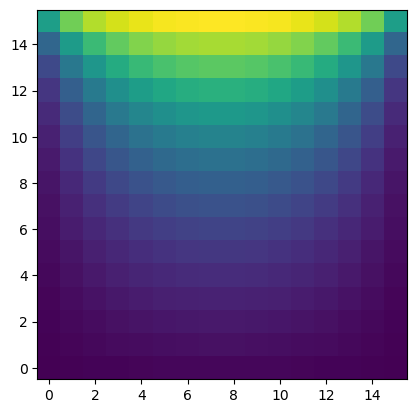

In [19]:
u = convert_solution(x)
plt.imshow(u.T,origin="lower")

Part 6:

Now we have tested our code, we could write a "solver" function to wrap all necessary codes.\
This solver function could be either in the notebook or in a seperate python file.

In [20]:
def solve_laplace(N=16):
    A = generate_the_laplace_matrix_with_size(N=N)
    b = generate_the_rhs_vector_with_size(N=N)
    x = linalg.solve(A,b)
    u = convert_solution(x)
    return u

In [21]:
u = solve_laplace(N=64)

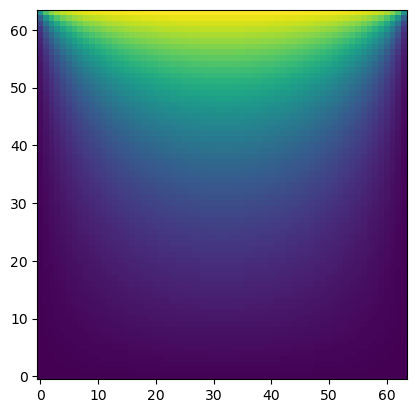

In [22]:
plt.imshow(u.T,origin="lower")

In [23]:
field = np.gradient(u)

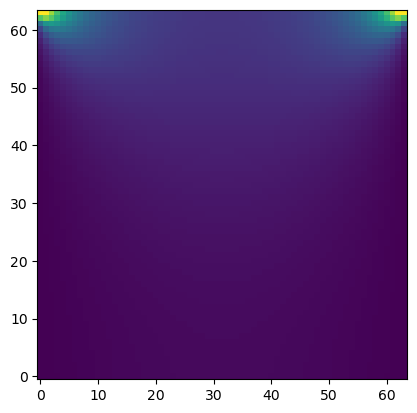

In [24]:
plt.imshow(field[1].T,origin="lower")

Part 7:

The buttole neck of this solver is in the `linalg.solve()`.\
Let's measure the performance of `linalg.solve()` with different resolutions.

In [25]:
import time

In [26]:
resolutions = np.array([8,16,32,64,128])
times       = np.zeros(len(resolutions))

for i, N in enumerate(resolutions):
    print("Measuring resolution N = ", N)
    A = generate_the_laplace_matrix_with_size(N)
    b = generate_the_rhs_vector_with_size(N)
    t1 = time.time()
    x  = linalg.solve(A,b)
    t2 = time.time()
    times[i] = (t2-t1)

Measuring resolution N =  8
Measuring resolution N =  16
Measuring resolution N =  32
Measuring resolution N =  64
Measuring resolution N =  128


Part 8:

Plot Computing time vs N in log-log scale.

Text(0, 0.5, 'Times [sec]')

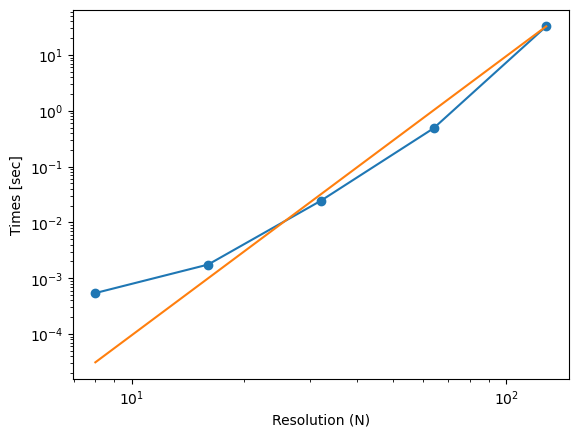

In [27]:
plt.figure(1)
plt.plot(resolutions,times,'-o')
plt.plot(resolutions,times[-1]*resolutions**5/resolutions[-1]**5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Resolution (N)")
plt.ylabel("Times [sec]")

You could see that the perofmance is propotional to `N^5`!\
This is becasue the size of the matrix A is proportional to `N^2` and\
the calculation time of `linalg.solve(M,b)` is proportial to the cubic of the size of M, N^3,\
giving `N^5` at the end.

The `scipy.linalg.solve` is robust, but since the matrix A is a sparse matrix, we could use special method to solve it.
* sparse matrix: most element are zero, therefore we can compress it to reduce the storage of memory

REF: https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.spsolve.html

In [28]:
from scipy.sparse import csc_matrix
import scipy.sparse.linalg as splinalg

In [29]:
N = 16
A = generate_the_laplace_matrix_with_size(N)
A = csc_matrix(A)
b = generate_the_rhs_vector_with_size(N)
x = splinalg.spsolve(A,b)

Let's measure the performance again with `spsolve()`

In [30]:
resolutions = np.array([8,16,32,64,128,256])
times_sp    = np.zeros(len(resolutions))

for i, N in enumerate(resolutions):
    print("Measuring resolution N = ", N)
    A = generate_the_laplace_matrix_with_size(N)
    A = csc_matrix(A)
    b = generate_the_rhs_vector_with_size(N)
    t1 = time.time()
    x  = splinalg.spsolve(A,b)
    t2 = time.time()
    times_sp[i] = (t2-t1)

Measuring resolution N =  8
Measuring resolution N =  16
Measuring resolution N =  32
Measuring resolution N =  64
Measuring resolution N =  128
Measuring resolution N =  256


Text(0, 0.5, 'Times [sec]')

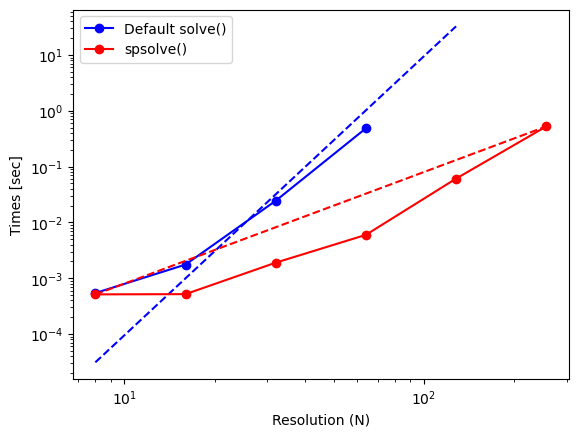

In [31]:
resolutions1 = np.array([8,16,32,64,128])

plt.figure(1)
plt.plot(resolutions1[:-1],times[:-1],'b-o',label="Default solve()")
plt.plot(resolutions1,times[-1]*resolutions1**5/resolutions1[-1]**5,'b--')
plt.plot(resolutions,times_sp,'r-o', label="spsolve()")
plt.plot(resolutions,times_sp[-1]*resolutions**2/resolutions[-1]**2,'r--')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left')
plt.xlabel("Resolution (N)")
plt.ylabel("Times [sec]")

You got several oreders of speedup if you know the matrix is a sparse matrix.